## Author = 'Kazutoki Matsui'

In [12]:
##  Import necessary packages
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('k=4.csv')
df = df[df['k_mean'] == 3]

In [3]:
'''(a) Winsorize rows outside three standard deviations'''
df = df[(np.abs(stats.zscore(df[['price','sqfeet']])) < 3).all(axis=1)]

'''(b) Create a column of pets_allowed'''
temp = df[['cats_allowed', 'dogs_allowed']].apply(sum, axis=1)
pets_allowed = []
for t in temp:
  if t == 0:
    pets_allowed.append(0)
  else:
    pets_allowed.append(1)
df['pets_allowed'] = pets_allowed

'''(c) Drop category of "assisted Living" and "land" as this seems to be an outlier'''
df = df[df['type'] !='assisted living']
df = df[df['type'] !='land']

'''(d) Create a park_dummy'''
park_2 = ['attached garage']
park_0 = ['off-street parking']
park_dummy = []
for park in df['parking_options']:
  if park in park_2:
    park_dummy.append('two')
  elif park in park_0:
    park_dummy.append('zero')
  else:
    park_dummy.append('one')
df['park_dummy'] = park_dummy

'''(e) Create a laundry_dummy'''
in_unit = ['w/d in unit']
in_building = ['laundry on site','w/d hookups','laundry in bldg']
no_laundry = ['no laundry on site']

laundry_dummy = []
for laundry in df['laundry_options']:
  if laundry in in_unit:
    laundry_dummy.append('in_unit')
  elif laundry in no_laundry:
    laundry_dummy.append('no_laundry')
  else:
    laundry_dummy.append('in_building')
df['laundry_dummy'] = laundry_dummy

'''(f) Drop outlier states'''
states = ['fl','ga','tn','sc','al','la','ky','ms','nc','il','in']
df = df[df['state'].isin(states)]

'''(g) Convert boolean columns into zero-one'''
bool_cols = ['smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished','comes_furnished']
bool_vars = df[bool_cols]
df[bool_cols] = df[bool_cols].astype(int)

'''(h) Select only columns for modeling'''
df_processed = df.copy()[['price','type','pets_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished',
                              'laundry_dummy','park_dummy','sqfeet','beds','baths','lat','long','state']]

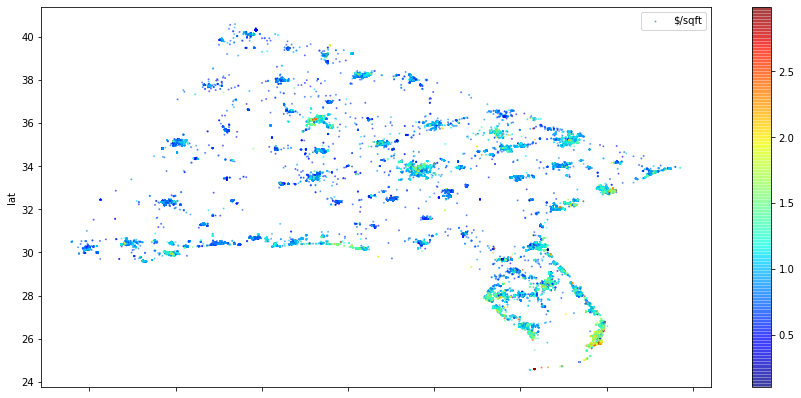

In [13]:
## Plotting the latitude and longitude of cleaned dataset
df_processed.plot(kind='scatter', x='long', y='lat', alpha=0.5,
         s=1, label='$/sqft',  
         c=df_processed['price']/df_processed['sqfeet'],   #  set symbol color on house value 
         cmap=plt.get_cmap('jet'),      
         colorbar=True,
         figsize=(15,7))
plt.legend()
## Looks like I got SouthEast part of the US!

In [4]:
y = df_processed['price']
X = df_processed.drop(columns=['price'])
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cat_cols = ['type','laundry_dummy','park_dummy','state']
con_cols = ['sqfeet','beds','baths']
preprocessor_ohe = ColumnTransformer(transformers=[('cat', OneHotEncoder(categories='auto'), cat_cols),
                                                   ('cont', StandardScaler(), con_cols)])
X_train_ohe = preprocessor_ohe.fit_transform(X_train_raw)
X_test_ohe = preprocessor_ohe.transform(X_test_raw)

joblib.dump(preprocessor_ohe, "preprocessor.joblib")

['preprocessor.joblib']

In [33]:
rf_reg = ensemble.RandomForestRegressor(n_estimators=200,  # number of trees
                                        criterion='mse',  # how to measure fit
                                        max_depth=None,  # how deep tree nodes can go
                                        min_samples_split=2,  # samples needed to split node
                                        min_samples_leaf=1,  # samples needed for a leaf
                                        min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                        max_features='auto',  # max feats
                                        max_leaf_nodes=None,  # max nodes
                                        n_jobs=1, # how many to run parallel
                                        random_state=42)

model = rf_reg.fit(X_train_ohe, y_train.ravel())
joblib.dump(model, 'se-model.joblib')

['se-model.joblib']

In [41]:
from sklearn.metrics import mean_squared_error
y_test_pred = model.predict(X_test_ohe)
y_train_pred = model.predict(X_train_ohe)

rf_mse = mean_squared_error(y_test, y_test_pred) 
rf_rmse = np.sqrt(rf_mse) 
print('The RMSE is: ',rf_rmse)

norm_rmse = rf_rmse / (y_test.max() - y_test.min())
print('The Normalized RMSE is ', norm_rmse)

# R-Squared score
print('The R2 score is: ', model.score(X_test_ohe, y_test))

The RMSE is:  150.17744901591158
The Normalized RMSE is  0.0708384193471281
The R2 score is:  0.7800812508749955


In [7]:
def centroid(train):
    return np.array([train['lat'].sum(), train['long'].sum()]) / len(train)

centroid_3 = centroid(X_train_raw)
print(centroid_3)

[ 32.47957082 -84.44073655]


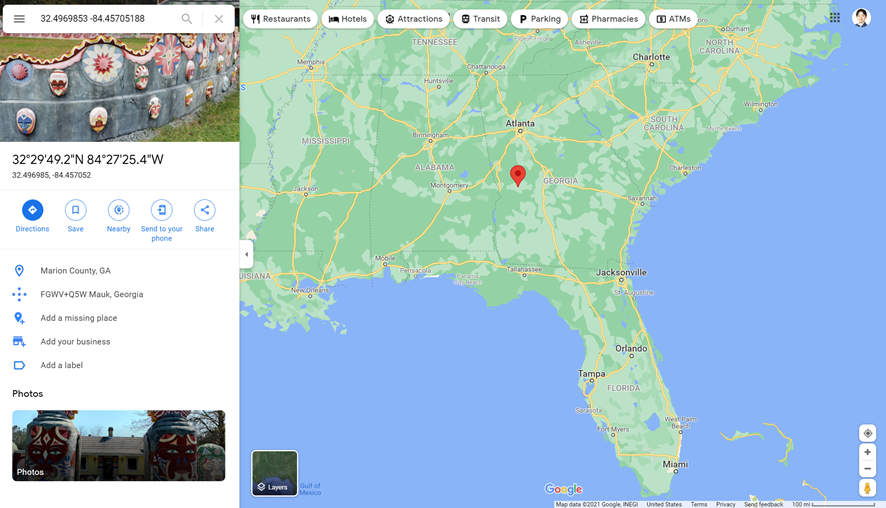

## Check if the transformation and prediction are working

In [35]:
datapoint = {'lat': [50.0], # example [1.0]
          'long': [-80.0], # example [2.0]
          'beds': [2.0], # example [1.0]
          'baths': [2.0], # example [2.0]
          'sqfeet': [1000.0], # example [1000.0]
          'state': ['fl'], # example ['ca']
          'type': ['apartment'], # example ['apartment']
          'laundry_options': ['w/d in unit'], # example ['nan']
          'parking_options': ['off-street parking'], # example ['nan']
          'cats_allowed': [True], # example [True] 
          'dogs_allowed': [True], # example [False]
          'smoking_allowed': [False], # example [False]
          'wheelchair_access': [True] , # example [True] 
          'electric_vehicle_charge': [False], # example [False] 
          'comes_furnished': [True]} # example [True]

In [36]:
from southeast import SouthEast
point_transformed = SouthEast().transform(datapoint)
point_transformed.shape

(1, 30)

In [37]:
model = joblib.load('se-model.joblib')
pred_value = model.predict(point_transformed)
print(pred_value)

[1296.55897545]
